# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

USING SGD with lr = 0.001 and momentum = 0.9 AND DECAY = 0.9 EVERY 100 EPOCHS FOR 500 EPOCHS

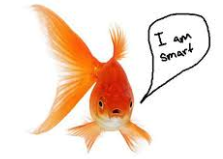

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = '/home/jquach12/jq_shenanigans/data/blackAndWhite_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation','testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

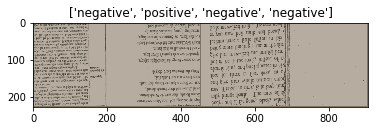

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'validation']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(31360,64).cuda()
        self.fc2 = nn.Linear(64, 25).cuda()
        self.fc3 = nn.Linear(25,2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [9]:
trainLosses = []
valLosses = []

trainAccs = []
valAccs = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    for epoch in range(num_epochs):
        cm_posAndNeg = tnt.meter.ConfusionMeter(2)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'validation':
                    cm_posAndNeg.add(outputs.data, labels.data)
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainLosses.append(epoch_loss)
                trainAccs.append(epoch_acc)
            elif phase == 'validation':
                valLosses.append(epoch_loss)
                valAccs.append(epoch_acc)
                
            if phase == 'validation':
                print('Confusion matrix:\n', cm_posAndNeg.conf)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model #got really high acc when if phase == 'val' i.e. this never happens
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
net1 = Net1()

In [11]:


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum = 0.9) #set lr a little high to decay later

# Decay LR by a factor of 0.9 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [12]:
num_epochs = 500
net1 = train_model(net1, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 1/500
----------
train Loss: 0.6934 Acc: 0.5154
Confusion matrix:
 [[ 30 138]
 [  4 164]]
validation Loss: 0.6891 Acc: 0.5774

Epoch 2/500
----------
train Loss: 0.6932 Acc: 0.5190
Confusion matrix:
 [[ 23 145]
 [  2 166]]
validation Loss: 0.6859 Acc: 0.5625

Epoch 3/500
----------
train Loss: 0.6848 Acc: 0.5557
Confusion matrix:
 [[ 23 145]
 [  2 166]]
validation Loss: 0.6806 Acc: 0.5625

Epoch 4/500
----------
train Loss: 0.6748 Acc: 0.5972
Confusion matrix:
 [[ 27 141]
 [  4 164]]
validation Loss: 0.6728 Acc: 0.5685

Epoch 5/500
----------
train Loss: 0.6625 Acc: 0.5960
Confusion matrix:
 [[ 30 138]
 [  4 164]]
validation Loss: 0.6588 Acc: 0.5774

Epoch 6/500
----------
train Loss: 0.6673 Acc: 0.5841
Confusion matrix:
 [[ 59 109]
 [  5 163]]
validation Loss: 0.6515 Acc: 0.6607

Epoch 7/500
----------
train Loss: 0.6589 Acc: 0.5877
Confusion matrix:
 [[ 33 135]
 [  4 164]]
validation Loss: 0.6462 Acc: 0.5863

Epoch 8/500
----------
train Loss: 0.6517 Acc: 0.5865
Confusion matri

Confusion matrix:
 [[134  34]
 [  2 166]]
validation Loss: 0.4031 Acc: 0.8929

Epoch 63/500
----------
train Loss: 0.5012 Acc: 0.7784
Confusion matrix:
 [[138  30]
 [  3 165]]
validation Loss: 0.3902 Acc: 0.9018

Epoch 64/500
----------
train Loss: 0.4764 Acc: 0.7998
Confusion matrix:
 [[137  31]
 [  4 164]]
validation Loss: 0.3808 Acc: 0.8958

Epoch 65/500
----------
train Loss: 0.4672 Acc: 0.7855
Confusion matrix:
 [[129  39]
 [  3 165]]
validation Loss: 0.3943 Acc: 0.8750

Epoch 66/500
----------
train Loss: 0.4697 Acc: 0.7938
Confusion matrix:
 [[136  32]
 [  3 165]]
validation Loss: 0.3800 Acc: 0.8958

Epoch 67/500
----------
train Loss: 0.4798 Acc: 0.7796
Confusion matrix:
 [[128  40]
 [  2 166]]
validation Loss: 0.4202 Acc: 0.8750

Epoch 68/500
----------
train Loss: 0.4656 Acc: 0.7820
Confusion matrix:
 [[135  33]
 [  4 164]]
validation Loss: 0.3955 Acc: 0.8899

Epoch 69/500
----------
train Loss: 0.4799 Acc: 0.7891
Confusion matrix:
 [[138  30]
 [  4 164]]
validation Loss: 0.3

Confusion matrix:
 [[128  40]
 [  6 162]]
validation Loss: 0.4644 Acc: 0.8631

Epoch 124/500
----------
train Loss: 0.4466 Acc: 0.8009
Confusion matrix:
 [[124  44]
 [  3 165]]
validation Loss: 0.4739 Acc: 0.8601

Epoch 125/500
----------
train Loss: 0.4395 Acc: 0.8009
Confusion matrix:
 [[105  63]
 [  3 165]]
validation Loss: 0.5089 Acc: 0.8036

Epoch 126/500
----------
train Loss: 0.4353 Acc: 0.7974
Confusion matrix:
 [[122  46]
 [  3 165]]
validation Loss: 0.4758 Acc: 0.8542

Epoch 127/500
----------
train Loss: 0.4293 Acc: 0.8045
Confusion matrix:
 [[119  49]
 [  4 164]]
validation Loss: 0.4973 Acc: 0.8423

Epoch 128/500
----------
train Loss: 0.4517 Acc: 0.8104
Confusion matrix:
 [[100  68]
 [  3 165]]
validation Loss: 0.5505 Acc: 0.7887

Epoch 129/500
----------
train Loss: 0.4499 Acc: 0.7927
Confusion matrix:
 [[ 92  76]
 [  3 165]]
validation Loss: 0.5281 Acc: 0.7649

Epoch 130/500
----------
train Loss: 0.4390 Acc: 0.8069
Confusion matrix:
 [[125  43]
 [  4 164]]
validation Lo

train Loss: 0.4046 Acc: 0.8270
Confusion matrix:
 [[106  62]
 [  5 163]]
validation Loss: 0.5011 Acc: 0.8006

Epoch 185/500
----------
train Loss: 0.3995 Acc: 0.8282
Confusion matrix:
 [[127  41]
 [ 12 156]]
validation Loss: 0.4662 Acc: 0.8423

Epoch 186/500
----------
train Loss: 0.4424 Acc: 0.7915
Confusion matrix:
 [[110  58]
 [  3 165]]
validation Loss: 0.5037 Acc: 0.8185

Epoch 187/500
----------
train Loss: 0.4404 Acc: 0.8128
Confusion matrix:
 [[ 83  85]
 [  3 165]]
validation Loss: 0.5903 Acc: 0.7381

Epoch 188/500
----------
train Loss: 0.3803 Acc: 0.8329
Confusion matrix:
 [[113  55]
 [  5 163]]
validation Loss: 0.5170 Acc: 0.8214

Epoch 189/500
----------
train Loss: 0.4247 Acc: 0.8199
Confusion matrix:
 [[114  54]
 [  7 161]]
validation Loss: 0.4849 Acc: 0.8185

Epoch 190/500
----------
train Loss: 0.4269 Acc: 0.8152
Confusion matrix:
 [[128  40]
 [  5 163]]
validation Loss: 0.4393 Acc: 0.8661

Epoch 191/500
----------
train Loss: 0.4159 Acc: 0.8140
Confusion matrix:
 [[126

train Loss: 0.3909 Acc: 0.8258
Confusion matrix:
 [[123  45]
 [ 13 155]]
validation Loss: 0.4678 Acc: 0.8274

Epoch 246/500
----------
train Loss: 0.3706 Acc: 0.8258
Confusion matrix:
 [[132  36]
 [ 10 158]]
validation Loss: 0.4062 Acc: 0.8631

Epoch 247/500
----------
train Loss: 0.3919 Acc: 0.8164
Confusion matrix:
 [[126  42]
 [ 25 143]]
validation Loss: 0.5058 Acc: 0.8006

Epoch 248/500
----------
train Loss: 0.3969 Acc: 0.8211
Confusion matrix:
 [[132  36]
 [  8 160]]
validation Loss: 0.3686 Acc: 0.8690

Epoch 249/500
----------
train Loss: 0.3885 Acc: 0.8223
Confusion matrix:
 [[127  41]
 [ 24 144]]
validation Loss: 0.4623 Acc: 0.8065

Epoch 250/500
----------
train Loss: 0.3616 Acc: 0.8353
Confusion matrix:
 [[131  37]
 [  4 164]]
validation Loss: 0.3490 Acc: 0.8780

Epoch 251/500
----------
train Loss: 0.4031 Acc: 0.8246
Confusion matrix:
 [[ 52 116]
 [  4 164]]
validation Loss: 0.6575 Acc: 0.6429

Epoch 252/500
----------
train Loss: 0.3928 Acc: 0.8306
Confusion matrix:
 [[100

train Loss: 0.3565 Acc: 0.8531
Confusion matrix:
 [[ 80  88]
 [ 42 126]]
validation Loss: 0.7133 Acc: 0.6131

Epoch 307/500
----------
train Loss: 0.3782 Acc: 0.8389
Confusion matrix:
 [[90 78]
 [91 77]]
validation Loss: 0.8416 Acc: 0.4970

Epoch 308/500
----------
train Loss: 0.3648 Acc: 0.8495
Confusion matrix:
 [[120  48]
 [ 25 143]]
validation Loss: 0.4678 Acc: 0.7827

Epoch 309/500
----------
train Loss: 0.3695 Acc: 0.8235
Confusion matrix:
 [[127  41]
 [ 29 139]]
validation Loss: 0.4744 Acc: 0.7917

Epoch 310/500
----------
train Loss: 0.3968 Acc: 0.8211
Confusion matrix:
 [[140  28]
 [ 19 149]]
validation Loss: 0.3705 Acc: 0.8601

Epoch 311/500
----------
train Loss: 0.3741 Acc: 0.8412
Confusion matrix:
 [[121  47]
 [ 18 150]]
validation Loss: 0.4764 Acc: 0.8065

Epoch 312/500
----------
train Loss: 0.3767 Acc: 0.8306
Confusion matrix:
 [[127  41]
 [ 13 155]]
validation Loss: 0.4106 Acc: 0.8393

Epoch 313/500
----------
train Loss: 0.3692 Acc: 0.8294
Confusion matrix:
 [[143  25

train Loss: 0.3457 Acc: 0.8495
Confusion matrix:
 [[103  65]
 [ 31 137]]
validation Loss: 0.6034 Acc: 0.7143

Epoch 368/500
----------
train Loss: 0.3743 Acc: 0.8329
Confusion matrix:
 [[124  44]
 [ 18 150]]
validation Loss: 0.4172 Acc: 0.8155

Epoch 369/500
----------
train Loss: 0.3685 Acc: 0.8270
Confusion matrix:
 [[126  42]
 [ 16 152]]
validation Loss: 0.3846 Acc: 0.8274

Epoch 370/500
----------
train Loss: 0.3703 Acc: 0.8223
Confusion matrix:
 [[133  35]
 [  9 159]]
validation Loss: 0.3333 Acc: 0.8690

Epoch 371/500
----------
train Loss: 0.3575 Acc: 0.8341
Confusion matrix:
 [[ 91  77]
 [  8 160]]
validation Loss: 0.5983 Acc: 0.7470

Epoch 372/500
----------
train Loss: 0.3479 Acc: 0.8353
Confusion matrix:
 [[ 88  80]
 [ 20 148]]
validation Loss: 0.6683 Acc: 0.7024

Epoch 373/500
----------
train Loss: 0.3577 Acc: 0.8602
Confusion matrix:
 [[ 79  89]
 [ 10 158]]
validation Loss: 0.5725 Acc: 0.7054

Epoch 374/500
----------
train Loss: 0.3868 Acc: 0.8223
Confusion matrix:
 [[126

train Loss: 0.3669 Acc: 0.8400
Confusion matrix:
 [[122  46]
 [ 28 140]]
validation Loss: 0.4916 Acc: 0.7798

Epoch 429/500
----------
train Loss: 0.3236 Acc: 0.8519
Confusion matrix:
 [[108  60]
 [ 22 146]]
validation Loss: 0.6171 Acc: 0.7560

Epoch 430/500
----------
train Loss: 0.3623 Acc: 0.8519
Confusion matrix:
 [[100  68]
 [ 13 155]]
validation Loss: 0.5217 Acc: 0.7589

Epoch 431/500
----------
train Loss: 0.3183 Acc: 0.8590
Confusion matrix:
 [[118  50]
 [ 37 131]]
validation Loss: 0.5193 Acc: 0.7411

Epoch 432/500
----------
train Loss: 0.3561 Acc: 0.8389
Confusion matrix:
 [[140  28]
 [ 54 114]]
validation Loss: 0.4539 Acc: 0.7560

Epoch 433/500
----------
train Loss: 0.3291 Acc: 0.8661
Confusion matrix:
 [[118  50]
 [  9 159]]
validation Loss: 0.4797 Acc: 0.8244

Epoch 434/500
----------
train Loss: 0.3490 Acc: 0.8460
Confusion matrix:
 [[114  54]
 [ 20 148]]
validation Loss: 0.4966 Acc: 0.7798

Epoch 435/500
----------
train Loss: 0.3312 Acc: 0.8531
Confusion matrix:
 [[136

train Loss: 0.2977 Acc: 0.8649
Confusion matrix:
 [[106  62]
 [ 51 117]]
validation Loss: 0.6285 Acc: 0.6637

Epoch 490/500
----------
train Loss: 0.3408 Acc: 0.8637
Confusion matrix:
 [[138  30]
 [ 74  94]]
validation Loss: 0.5524 Acc: 0.6905

Epoch 491/500
----------
train Loss: 0.2917 Acc: 0.8756
Confusion matrix:
 [[128  40]
 [ 48 120]]
validation Loss: 0.5253 Acc: 0.7381

Epoch 492/500
----------
train Loss: 0.3217 Acc: 0.8602
Confusion matrix:
 [[ 95  73]
 [ 33 135]]
validation Loss: 0.6780 Acc: 0.6845

Epoch 493/500
----------
train Loss: 0.3556 Acc: 0.8531
Confusion matrix:
 [[123  45]
 [ 52 116]]
validation Loss: 0.5194 Acc: 0.7113

Epoch 494/500
----------
train Loss: 0.3049 Acc: 0.8720
Confusion matrix:
 [[123  45]
 [ 30 138]]
validation Loss: 0.4687 Acc: 0.7768

Epoch 495/500
----------
train Loss: 0.3350 Acc: 0.8602
Confusion matrix:
 [[108  60]
 [ 35 133]]
validation Loss: 0.5672 Acc: 0.7173

Epoch 496/500
----------
train Loss: 0.3521 Acc: 0.8519
Confusion matrix:
 [[103

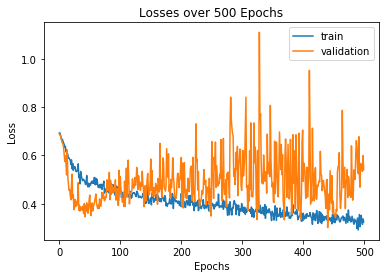

Average Training Loss: 0.407251493960788
Average Validation Loss: 0.49546680932624715
Average Training Accuracy: 0.8150568720379148
Average Validation Accuracy: 0.7901369047619048


In [16]:
plt.plot(trainLosses,label = "train")
plt.plot(valLosses,label = "validation")
plt.title("Losses over " + str(num_epochs) +  " Epochs")
plt.ylabel('Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()


print("Average Training Loss: " + str(np.mean(trainLosses)))
print("Average Validation Loss: " + str(np.mean(valLosses)))
print("Average Training Accuracy: " + str(np.mean(trainAccs)))
print("Average Validation Accuracy: " + str(np.mean(valAccs)))

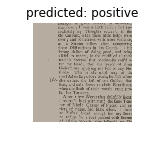

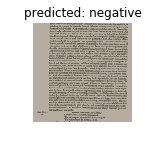

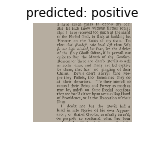

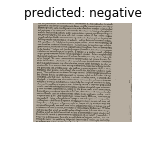

In [14]:
visualize_model(net1,4)

plt.ioff()
plt.show()

In [17]:
torch.save(net1.state_dict(), '/home/jquach12/net1_weight500ep.pt')
torch.save(net1, '/home/jquach12/net1_model500ep.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
